### Daytum Course: Spatial Data Analytics

### Multivariate Analysis in Python 

Here's a simple workflow, demonstration of multivariate analysis for subsurface modeling workflows. This should help you get started with building subsurface models that integrate uncertainty in the sample statistics.  

#### Bivariate Analysis

Understand and quantify the relationship between two variables

* example: relationship between porosity and permeability
* how can we use this relationship?

What would be the impact if we ignore this relationship and simply modeled porosity and permeability independently?

* no relationship beyond constraints at data locations
* independent away from data
* nonphysical results, unrealistic uncertainty models

#### Bivariate Statistics

Pearson’s Product‐Moment Correlation Coefficient
* Provides a measure of the degree of linear relationship.
* We refer to it as the 'correlation coefficient'

Let's review the sample variance of variable $x$. Of course, I'm truncating our notation as $x$ is a set of samples a locations in our modeling space, $x(\bf{u_\alpha}), \, \forall \, \alpha = 0, 1, \dots, n - 1$.

\begin{equation}
\sigma^2_{x}  = \frac{\sum_{i=1}^{n} (x_i - \overline{x})^2}{(n-1)}
\end{equation}

We can expand the the squared term and replace on of them with $y$, another variable in addition to $x$.

\begin{equation}
C_{xy}  = \frac{\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}{(n-1)}
\end{equation}

We now have a measure that represents the manner in which variables $x$ and $y$ co-vary or vary together.  We can standardized the covariance by the product of the standard deviations of $x$ and $y$ to calculate the correlation coefficent. 

\begin{equation}
\rho_{xy}  = \frac{\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}{(n-1)\sigma_x \sigma_y}, \, -1.0 \le \rho_{xy} \le 1.0
\end{equation}

In summary we can state that the correlation coefficient is related to the covariance as:

\begin{equation}
\rho_{xy}  = \frac{C_{xy}}{\sigma_x \sigma_y}
\end{equation}

The Person's correlation coefficient is quite sensitive to outliers and depature from linear behavoir (in the bivariate sense).  We have an altenrative known as the Spearman's rank correlations coefficient.   

\begin{equation}
\rho_{R_x R_y}  = \frac{\sum_{i=1}^{n} (R_{x_i} - \overline{R_x})(R_{y_i} - \overline{R_y})}{(n-1)\sigma_{R_x} \sigma_{R_y}}, \, -1.0 \le \rho_{xy} \le 1.0
\end{equation}

The rank correlation applies the rank transform to the data prior to calculating the correlation coefficent.  To calculate the rank transform simply replace the data values with the rank $R_x = 1,\dots,n$, where $n$ is the maximum value and $1$ is the minimum value. 

\begin{equation}
x_\alpha, \, \forall \alpha = 1,\dots, n, \, | \, x_i \ge x_j \, \forall \, i \gt j 
\end{equation}

\begin{equation}
R_{x_i} = i
\end{equation}

The corelation coefficients provide useful metrics to quantify relationships between two variables at a time. We can also consider bivariate scatter plots and matrix scatter plots to visualize multivariate data. In general, current practical subsurface modeling is bivariate, two variables at a time.    

#### Multivariate Statistics

See lecture on Multivariate Statistics, including the concepts of joint, conditional and marginal probability.

#### Load the required libraries

The following code loads the required libraries.   

In [1]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        

We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from matplotlib.colors import ListedColormap # custom color maps
from scipy import stats                   # summary statistics
import math                               # trig etc.
import scipy.signal as signal             # kernel for moving window calculation
import random
import seaborn as sns                     # advanced plotting
import warnings
warnings.filterwarnings('ignore')         # supress warnings

#### Design Custom Color Map

Accounting for significance by masking nonsignificant values

* for demonstration only currently, could be updated for each plot based on results confidence and uncertainty

In [3]:
my_colormap = plt.cm.get_cmap('RdBu_r', 256)            # make a custom colormap
newcolors = my_colormap(np.linspace(0, 1, 256))         # define colormap space
white = np.array([250/256, 250/256, 250/256, 1])        # define white color (4 channel)
#newcolors[26:230, :] = white                           # mask all correlations less than abs(0.8)
#newcolors[56:200, :] = white                           # mask all correlations less than abs(0.6)
newcolors[76:180, :] = white                            # mask all correlations less than abs(0.4)
signif = ListedColormap(newcolors)                      # assign as listed colormap
  
my_colormap = plt.cm.get_cmap('inferno', 256)           # make a custom colormap
newcolors = my_colormap(np.linspace(0, 1, 256))         # define colormap space
white = np.array([250/256, 250/256, 250/256, 1])        # define white color (4 channel)
#newcolors[26:230, :] = white                           # mask all correlations less than abs(0.8)
newcolors[0:12, :] = white                              # mask all correlations less than abs(0.6)
#newcolors[86:170, :] = white                           # mask all correlations less than abs(0.4)
sign1 = ListedColormap(newcolors)                       # assign as listed colormap

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [4]:
#os.chdir("c:/PGE383")                     # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  

In [5]:
#df = pd.read_csv('sample_data_MV_biased.csv') # load our data table
df = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_MV_biased.csv')

Visualizing the DataFrame would be useful and we already learned about these methods in this demo (https://git.io/fNgRW). 

We can preview the DataFrame by printing a slice or by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). With the slice we could look at any subset of the data table and with the head command, add parameter 'n=13' to see the first 13 rows of the dataset.  

In [6]:
print(df.iloc[0:5,:])                   # display first 4 samples in the table as a preview
df.head(n=13)                           # we could also use this command for a table preview

   Unnamed: 0      X      Y  Facies  Porosity        Perm           AI
0           0  100.0  900.0     0.0  0.101319    1.996868  5590.417154
1           1  100.0  800.0     1.0  0.147676   10.711789  3470.845666
2           2  100.0  700.0     1.0  0.145912   17.818143  3586.988513
3           3  100.0  600.0     1.0  0.186167  217.109365  3732.114787
4           4  100.0  500.0     1.0  0.146088   16.717367  2534.551236


,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
0,0,100.0,900.0,0.0,0.101319,1.996868,5590.417154
1,1,100.0,800.0,1.0,0.147676,10.711789,3470.845666
2,2,100.0,700.0,1.0,0.145912,17.818143,3586.988513
3,3,100.0,600.0,1.0,0.186167,217.109365,3732.114787
4,4,100.0,500.0,1.0,0.146088,16.717367,2534.551236
5,9,200.0,900.0,1.0,0.129949,23.348473,4781.590782
6,11,200.0,700.0,1.0,0.185299,595.674540,4729.017454
7,12,200.0,600.0,1.0,0.164923,154.555841,2147.668805
8,13,200.0,500.0,1.0,0.167026,50.970899,4583.679953
9,14,200.0,400.0,1.0,0.125382,4.061772,4477.930200


#### Summary Statistics for Tabular Data

The table includes X and Y coordinates (meters), Facies 1 and 0 (1 is sandstone and 0 interbedded sand and mudstone), Porosity (fraction), and permeability as Perm (mDarcy). 

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a nice data table. We use transpose just to flip the table so that features are on the rows and the statistics are on the columns.

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,368.0,293.260870,169.058258,0.000000,150.500000,296.000000,439.500000,586.000000
X,368.0,499.565217,289.770794,0.000000,240.000000,500.000000,762.500000,990.000000
Y,368.0,520.644022,277.412187,9.000000,269.000000,539.000000,769.000000,999.000000
Facies,368.0,0.597826,0.491004,0.000000,0.000000,1.000000,1.000000,1.000000
Porosity,368.0,0.127026,0.030642,0.041122,0.103412,0.125842,0.148623,0.210258
Perm,368.0,85.617362,228.362654,0.094627,2.297348,10.377292,50.581288,1991.097723
AI,368.0,4791.736646,974.560569,1981.177309,4110.728374,4713.325533,5464.043562,7561.250336


#### Visualizing Tabular Data with Location Maps 

It is natural to set the x and y coordinate and feature ranges manually. e.g. do you want your color bar to go from 0.05887 to 0.24230 exactly? Also, let's pick a color map for display. I heard that plasma is known to be friendly to the color blind as the color and intensity vary together (hope I got that right, it was an interesting Twitter conversation started by Matt Hall from Agile if I recall correctly). We will assume a study area of 0 to 1,000m in x and y and omit any data outside this area.

In [8]:
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
pormin = 0.05; pormax = 0.25;           # range of porosity values
permmin = 0.01; permmax = 2000.0         # range of permeability values
AImin = 2000.0; AImax = 8000.0          # range of AI values
nx = 100; ny = 100; csize = 10.0
cmap = plt.cm.plasma                    # color map

Let's try out locmap. This is a reimplementation of GSLIB's locmap program that uses matplotlib. I hope you find it simpler than matplotlib, if you want to get more advanced and build custom plots lock at the source. If you improve it, send me the new code. 

Now we can populate the plotting parameters and visualize the porosity data.

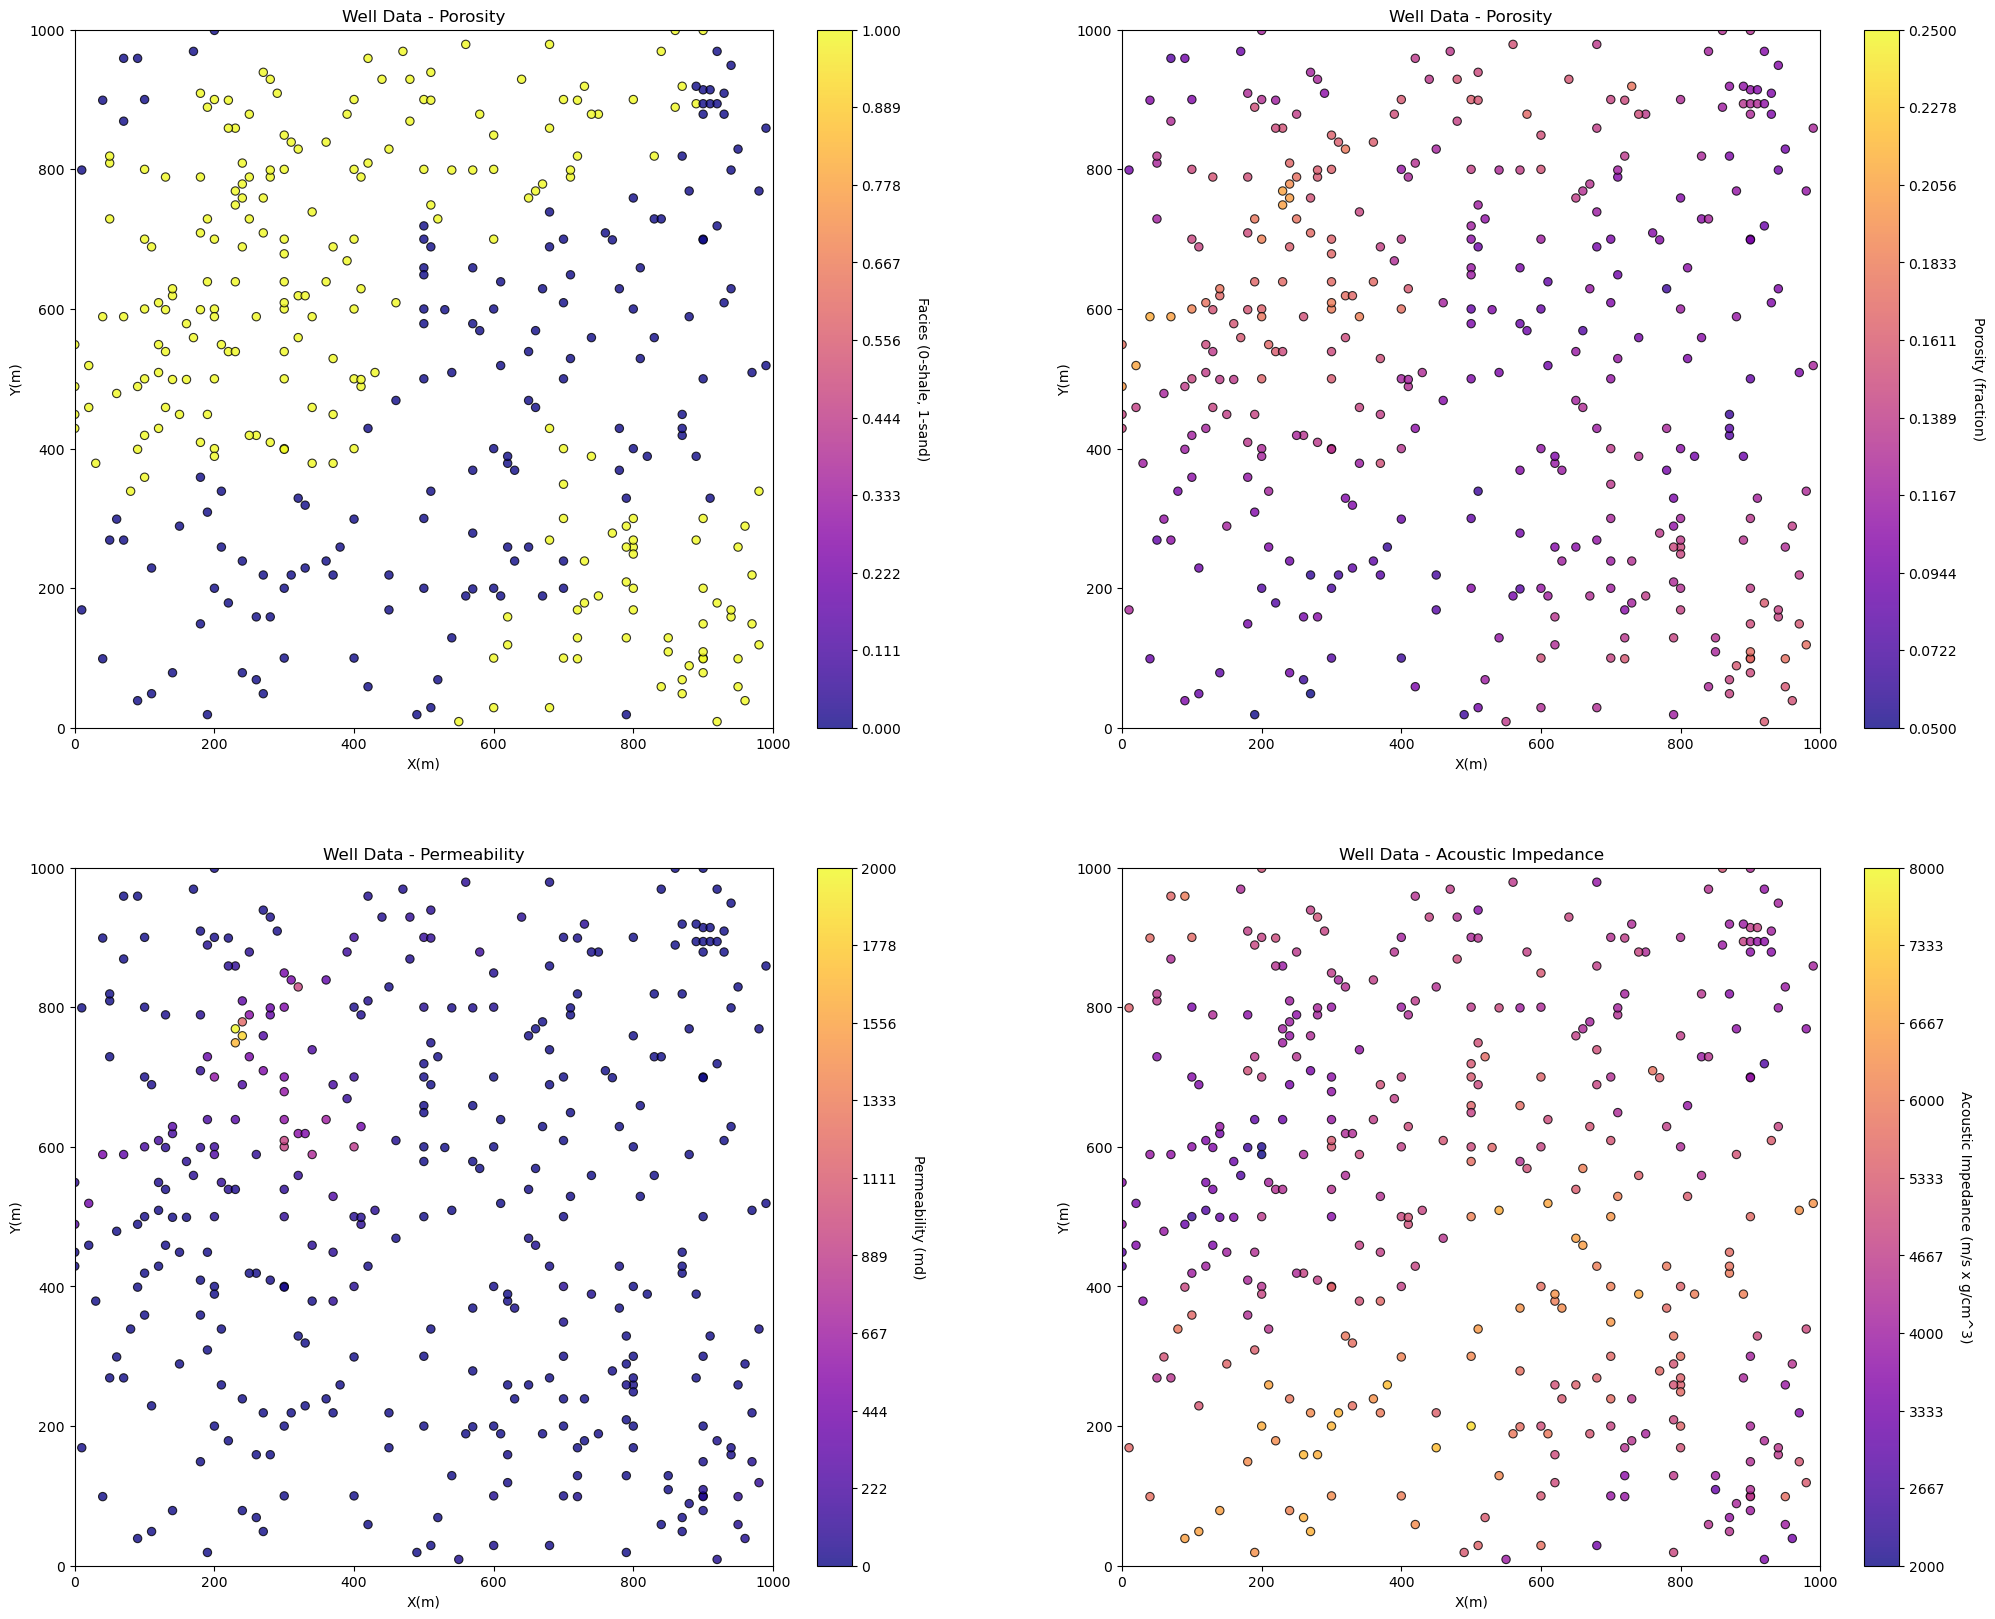

In [9]:
plt.subplot(221)
GSLIB.locmap_st(df,'X','Y','Facies',xmin,xmax,ymin,ymax,0,1,'Well Data - Porosity','X(m)','Y(m)','Facies (0-shale, 1-sand)',cmap)

plt.subplot(222)
GSLIB.locmap_st(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,'Well Data - Porosity','X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(223)
GSLIB.locmap_st(df,'X','Y','Perm',xmin,xmax,ymin,ymax,permmin,permmax,'Well Data - Permeability','X(m)','Y(m)','Permeability (md)',cmap)

plt.subplot(224)
GSLIB.locmap_st(df,'X','Y','AI',xmin,xmax,ymin,ymax,AImin,AImax,'Well Data - Acoustic Impedance','X(m)','Y(m)','Acoustic Impedance (m/s x g/cm^3)',cmap)


plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.2, wspace=0.2, hspace=0.2)
plt.show()

#### Bivariate Analysis

Let's start with some simple bivariate plotting and calculations. Firsty some scatter plots.

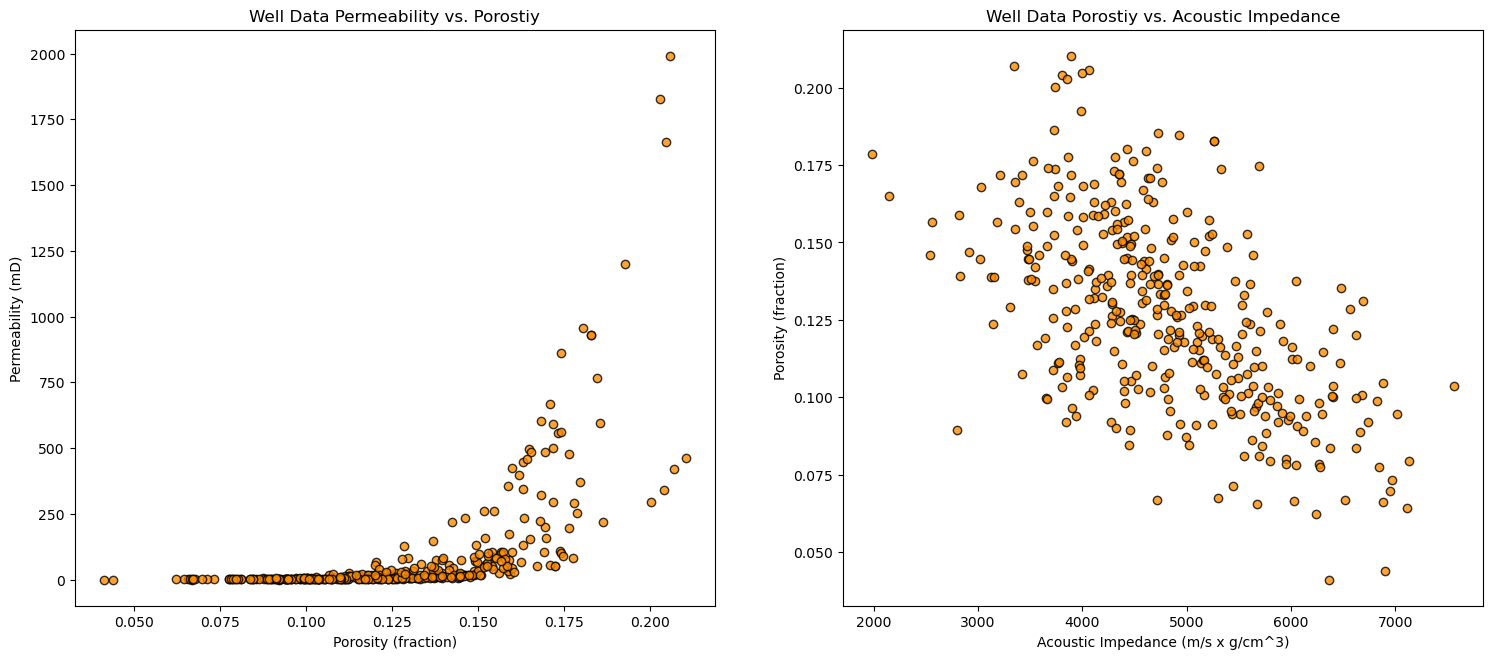

In [10]:
plt.subplot(121)
plt.plot(df['Porosity'].values,df['Perm'].values, 'o', label='', markerfacecolor='darkorange', markeredgecolor='black', alpha=0.8)
plt.title('Well Data Permeability vs. Porostiy')
plt.xlabel('Porosity (fraction)')
plt.ylabel('Permeability (mD)')
#plt.legend()

plt.subplot(122)
plt.plot(df['AI'].values,df['Porosity'].values, 'o', label='', markerfacecolor='darkorange', markeredgecolor='black', alpha=0.8)
plt.title('Well Data Porostiy vs. Acoustic Impedance')
plt.ylabel('Porosity (fraction)')
plt.xlabel('Acoustic Impedance (m/s x g/cm^3)')


plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.2, hspace=0.2)
#plt.savefig('Test.pdf', dpi=600, bbox_inches = 'tight',format='pdf')
plt.show()

#### Correlation and Covariance

It is straight forward to calculat the covariance and correlation from the pairs of data in our dataset. Here's the covariance.  Notice that the matrix is symmetrical?  Makes sense, as the $C_{Por,Perm} = C_{Perm,Por}$.  Also, note that the diagonal values ($C_{i,j}$ where $i=j$) equal to the variance.  We check porosity by calculating the variance.

In [11]:
print(df.iloc[:,3:7].cov())                    # the covariance matrix for columns 3,4,5 and 6 and all rows
print('The variance of porosity is ' + str(round(np.var(df['Porosity'].values),6)))

              Facies   Porosity          Perm             AI
Facies      0.241085   0.011370     33.010926    -248.032706
Porosity    0.011370   0.000939      4.055029     -17.132244
Perm       33.010926   4.055029  52149.501968  -46471.695092
AI       -248.032706 -17.132244 -46471.695092  949768.302409
The variance of porosity is 0.000936


Here's the correlation coefficient.

In [12]:
df.iloc[:,3:7].corr()

,Facies,Porosity,Perm,AI
Facies,1.000000,0.755682,0.294406,-0.518340
Porosity,0.755682,1.000000,0.579493,-0.573700
Perm,0.294406,0.579493,1.000000,-0.208812
AI,-0.518340,-0.573700,-0.208812,1.000000


#### Visualize the Correlation Matrix

It is convenient to visualize the correlation matrix as follows.

* I added a custom colour bar to communicate significance. Demonstration only, I did not calculate confidence intervals, but that could be added.

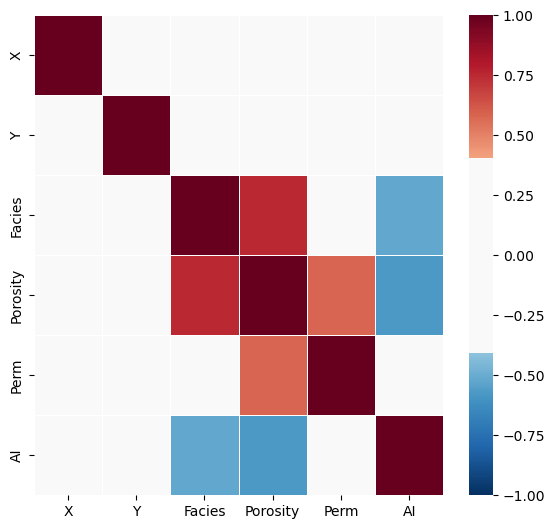

In [13]:
plt.subplot(111)                                        # plot correlation matrix with significance colormap
sns.heatmap(df.iloc[:,1:7].corr(),vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.8, top=1., wspace=0.2, hspace=0.2)
plt.show()

#### Rank Correlation Coefficient

In [14]:
rank_correlation, rank_correlation_pval = stats.spearmanr(df.iloc[:,1:7]) # calculate the range correlation coefficient
print('Rank Correlation:')
print(rank_correlation)
print('\nRank Correlation p-value:')
print(rank_correlation_pval)

Rank Correlation:
[[ 1.         -0.07357553 -0.17220559 -0.16606427 -0.27886601  0.08360199]
 [-0.07357553  1.          0.15085391  0.20171806  0.18916157 -0.35440765]
 [-0.17220559  0.15085391  1.          0.79973189  0.71923703 -0.50503617]
 [-0.16606427  0.20171806  0.79973189  1.          0.88314655 -0.56863773]
 [-0.27886601  0.18916157  0.71923703  0.88314655  1.         -0.34876935]
 [ 0.08360199 -0.35440765 -0.50503617 -0.56863773 -0.34876935  1.        ]]

Rank Correlation p-value:
[[0.00000000e+000 1.58973816e-001 9.09731115e-004 1.38839048e-003
  5.33816809e-008 1.09352069e-001]
 [1.58973816e-001 0.00000000e+000 3.72387503e-003 9.75577852e-005
  2.62849798e-004 2.48348363e-012]
 [9.09731115e-004 3.72387503e-003 0.00000000e+000 4.11417796e-083
  7.49150387e-060 3.24513314e-025]
 [1.38839048e-003 9.75577852e-005 4.11417796e-083 0.00000000e+000
  2.26847950e-122 6.59769641e-033]
 [5.33816809e-008 2.62849798e-004 7.49150387e-060 2.26847950e-122
  0.00000000e+000 5.77157354e-012]

#### Plot Correlation and Rank Correlation Matrices

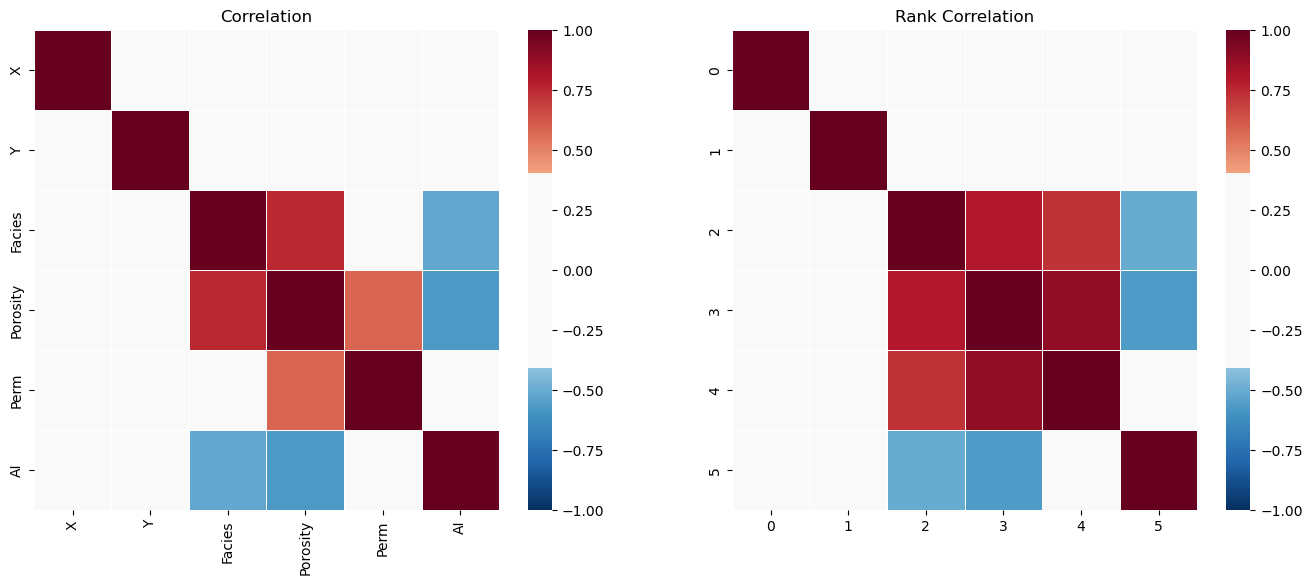

In [15]:
plt.subplot(121)                                        # plot correlation matrix with significance colormap
sns.heatmap(df.iloc[:,1:7].corr(),vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif)
plt.title('Correlation')

plt.subplot(122)                                        # plot correlation matrix with significance colormap
sns.heatmap(stats.spearmanr(df.iloc[:,1:7])[0],vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1., wspace=0.2, hspace=0.2)
plt.title('Rank Correlation')
plt.show()

#### Matrix Scatter Plots

If we have 3 or more variables to consider then matrix scatter plot offer an efficient method to display the multivariate relationships, 2 variables at a time.  Once can identify:

1. the range, envelope of the paired data
2. homoscedastic and heteroscedastic behavoirs
3. non-linear features

Here's the seaborn package matrix scatter plot function, pairplot. Let's color the results by facies.

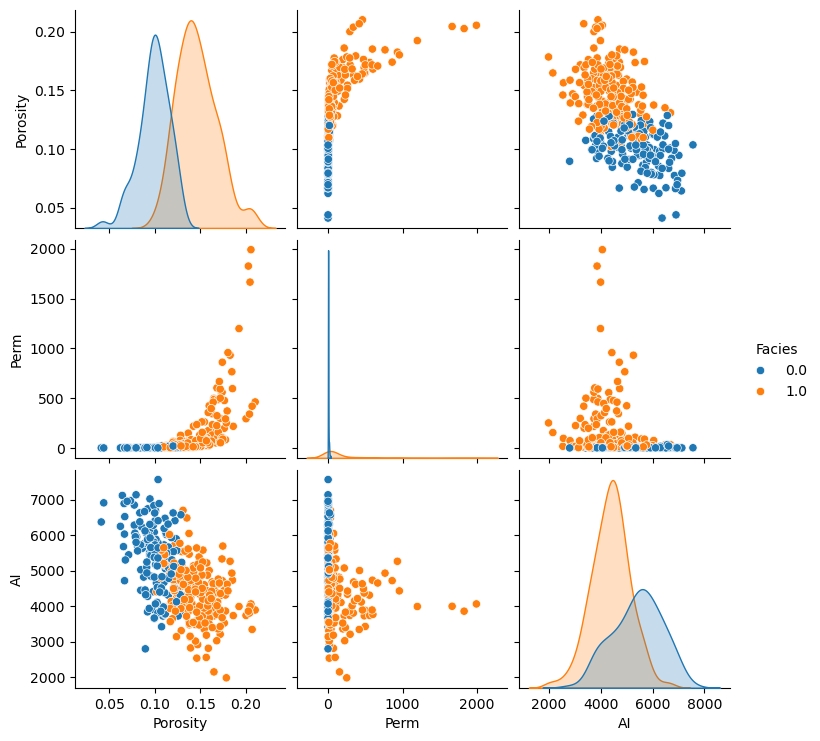

In [16]:
sns.pairplot(df, hue='Facies',vars=['Porosity','Perm','AI'],markers='o')

#### Pair Grid Plot

For maximum control of the resulting plot we can work with pair grid plots from seaborn.

* we can independently set lower, upper and diagonal components of the plot

We demostrate this with all facies pooled together for:

* scatter plots for upper

* histograms for diagonal

* kernel density plots for the lower

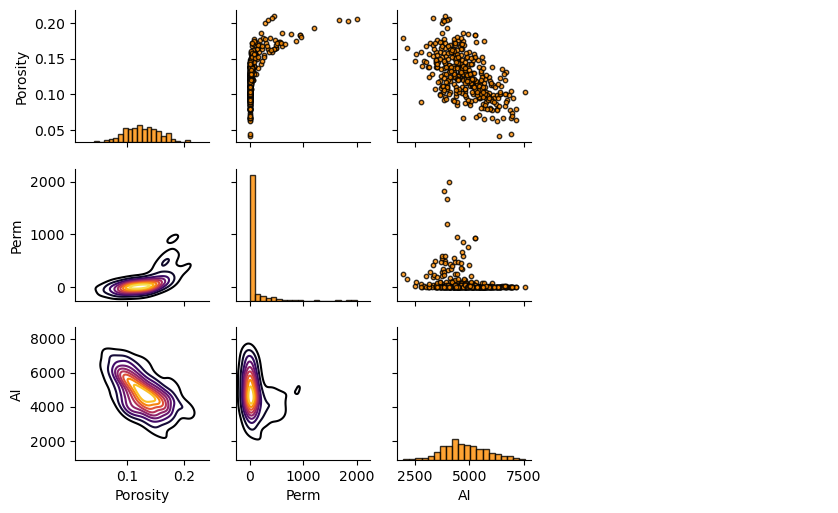

In [17]:
pairgrid = sns.PairGrid(df,vars=['Porosity','Perm','AI'])
pairgrid = pairgrid.map_upper(plt.scatter, color = 'darkorange', edgecolor = 'black', alpha = 0.8, s = 10)
pairgrid = pairgrid.map_diag(plt.hist, bins = 20, color = 'darkorange',alpha = 0.8, edgecolor = 'k')# Map a density plot to the lower triangle
pairgrid = pairgrid.map_lower(sns.kdeplot, cmap = plt.cm.inferno, 
                              shade = False, shade_lowest = False, alpha = 1.0, n_levels = 10)
pairgrid.add_legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.6, top=0.6, wspace=0.2, hspace=0.2)

#### Joint, Conditional and Marginals

We can use kernel density estimation to estimate the joint probabilities density function (pdf) for the paired data, a 2D pdf! We could use this to estimate any required joint, marginal and conditional probability (care must be taken with normalization). Let's use the seaborn package 'kdeplot' function to estimate the joint pdf for porosity and acoustic impedance. 

Text(0.5, 1.0, 'Porosity vs. Acoustic Impedance')

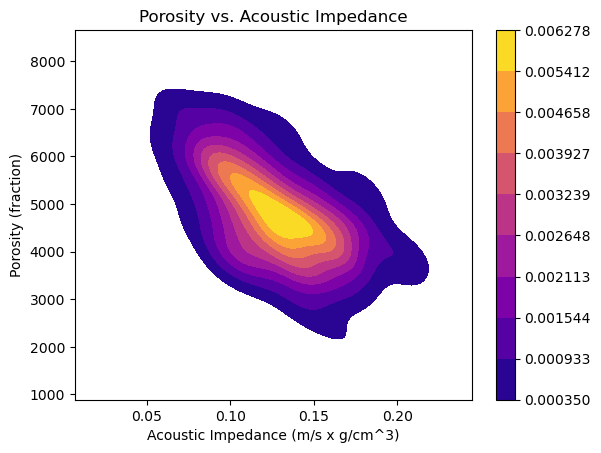

In [18]:
ax = sns.kdeplot(y=df['AI'].values,x=df['Porosity'].values, shade=True, n_levels = 10,cmap=cmap,cbar= True, shade_lowest = False)
ax.set_xlabel('Acoustic Impedance (m/s x g/cm^3)'); ax.set_ylabel('Porosity (fraction)'); ax.set_title('Porosity vs. Acoustic Impedance')

I think is it useful to visualize the joint pdfs with the marginal pdfs on a single plot. We can use seaborn's 'jointplot' to accomplish this. 

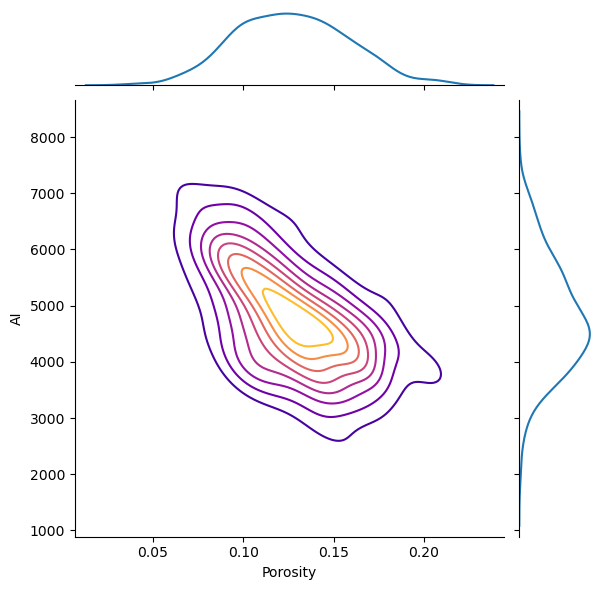

In [19]:
ax = sns.jointplot(data = df, y = 'AI',x = 'Porosity', kind='kde',shade = False, n_levels = 10,cmap=cmap, shade_lowest = True);

The correlation coefficient and the p-value of the correlation coefficient (significant if < $\alpha/2$ or > $1-\alpha/2$). 

#### Calculating Conditional Statistics

Of course, we could just calculate the conditional statistics by-hand. We need to select some bins over the variable that we will condition to. Let's calculate conditional statistical of porosity given acoustic impedance. We will select 9 equal spaced bins.  

In [20]:
AI_bins = np.linspace(2000,8000,10)            # set the bin boundaries and then the centroids for plotting
AI_centroids = np.linspace((AI_bins[0]+AI_bins[1])*0.5,(AI_bins[8]+AI_bins[9])*0.5,9)
print(AI_bins)                                 # check the boundaries
print(AI_centroids)                            # check the centroids
df['AI_bins'] = pd.cut(df['AI'], AI_bins,labels = AI_centroids) # cut on bondaries and lable with centroids 
df.head()                                      # check the new column in the DataFrame

[2000.         2666.66666667 3333.33333333 4000.         4666.66666667
 5333.33333333 6000.         6666.66666667 7333.33333333 8000.        ]
[2333.33333333 3000.         3666.66666667 4333.33333333 5000.
 5666.66666667 6333.33333333 7000.         7666.66666667]


,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,AI_bins
0,0,100.0,900.0,0.0,0.101319,1.996868,5590.417154,5666.666667
1,1,100.0,800.0,1.0,0.147676,10.711789,3470.845666,3666.666667
2,2,100.0,700.0,1.0,0.145912,17.818143,3586.988513,3666.666667
3,3,100.0,600.0,1.0,0.186167,217.109365,3732.114787,3666.666667
4,4,100.0,500.0,1.0,0.146088,16.717367,2534.551236,2333.333333


Now we can use the 'groupby' function built-in to Pandas' DataFrames to extract subsets of porosity values in each bin from the DataFrame and then to calculate the conditional statistics: expectation, P90 and P10. Let's plot the result. 

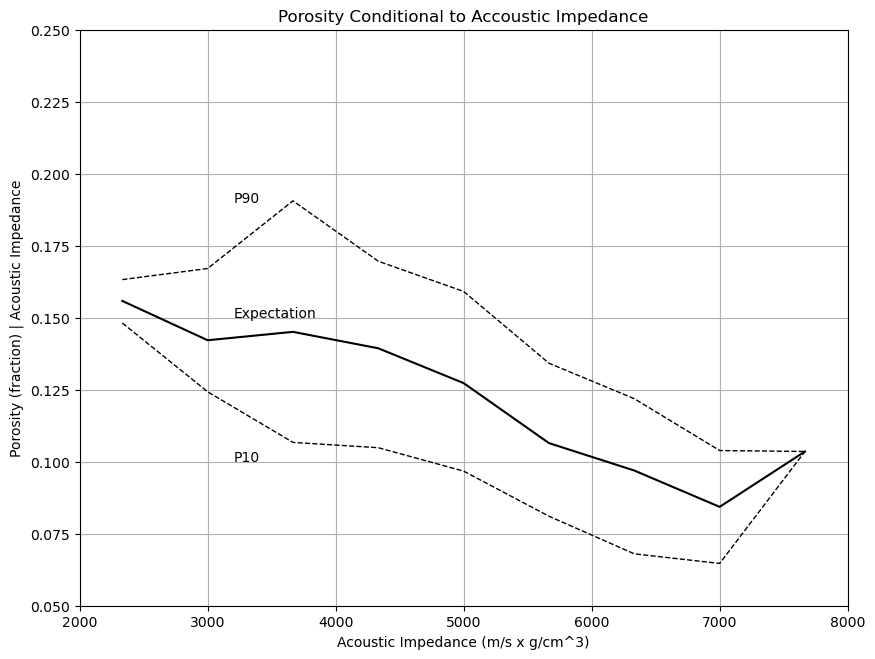

In [21]:
cond_exp = df.groupby('AI_bins')['Porosity'].mean()
cond_P90 = df.groupby('AI_bins')['Porosity'].quantile(.9)
cond_P10 = df.groupby('AI_bins')['Porosity'].quantile(.1)

plt.subplot(111)
plt.plot(AI_centroids,cond_exp,color='black')
plt.plot(AI_centroids,cond_P90,'r--',color='black',linewidth = 1.0)
plt.plot(AI_centroids,cond_P10,'r--',color='black',linewidth = 1.0)

plt.xlabel('Acoustic Impedance (m/s x g/cm^3)')
plt.ylabel('Porosity (fraction) | Acoustic Impedance')
t = plt.title('Porosity Conditional to Accoustic Impedance')
plt.ylim(pormin,pormax)
plt.xlim(AImin,AImax)
plt.text(3200, .10, 'P10')
plt.text(3200, .15, 'Expectation')
plt.text(3200, .19, 'P90')

plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

Does acoustic impedance provide information about porosity? 

Yes, clearly the conditional statistics vary over acoustic impedance, knowing the acoustic impedance reduces the uncertainty about porosity.

#### Comments

This was a basic demonstration of multivariate analysis. A lot more could be done, for example, there are methods that reduce the dimensionality, and remove dependency to allow for independent variable modeling workflows etc.

I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

<i>&copy; Copyright daytum 2021. All Rights Reserved</i>